# Imports
note book for random doodles

In [57]:
import functions as f


import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.precision', 4)
# pd.set_option('display.float_format', lambda x: f'{x:.4f}')

from scipy.stats import pearsonr, spearmanr


import matplotlib.pyplot as plt


import seaborn as sns

from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.datasets import load_wine
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, label_binarize
from sklearn.feature_selection import SelectKBest, RFE, RFECV, f_classif, mutual_info_classif
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
# from sklearn.linear_model import Lasso, Ridge  # For regularized regression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, GradientBoostingRegressor

# #metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, roc_curve, auc
# from sklearn.datasets import make_classification


# EDA

In [41]:
X,y  = load_wine(return_X_y=True, as_frame=True)
rng = np.random.RandomState(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=rng)
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [49]:
y.value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

In [43]:
model1 = LogisticRegression(max_iter=10000,random_state=rng)
model1.fit(X_train, y_train)

LogisticRegression(max_iter=10000,
                   random_state=RandomState(MT19937) at 0x20B06317040)

In [44]:
model2 = CalibratedClassifierCV(LogisticRegression(max_iter=10000, random_state=rng))
model2.fit(X_train, y_train)

CalibratedClassifierCV(estimator=LogisticRegression(max_iter=10000,
                                                    random_state=RandomState(MT19937) at 0x20B06317040))

In [45]:
y_pred1 = model1.predict(X_test)
y_proba1 = model1.predict_proba(X_test)
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       0.92      0.92      0.92        13
           2       1.00      0.89      0.94         9

    accuracy                           0.94        36
   macro avg       0.95      0.94      0.94        36
weighted avg       0.95      0.94      0.94        36



In [46]:
y_pred2 = model2.predict(X_test)
y_proba2 = model2.predict_proba(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.86      0.92      0.89        13
           2       1.00      0.89      0.94         9

    accuracy                           0.92        36
   macro avg       0.93      0.91      0.92        36
weighted avg       0.92      0.92      0.92        36



In [55]:
print(y_proba1[:5,:].round(3))
print('')
print(y_proba2[:5,:].round(3))

[[0.008 0.002 0.991]
 [0.    1.    0.   ]
 [0.994 0.003 0.004]
 [0.001 0.998 0.001]
 [1.    0.    0.   ]]

[[0.131 0.132 0.737]
 [0.013 0.937 0.05 ]
 [0.775 0.17  0.055]
 [0.14  0.805 0.055]
 [0.9   0.005 0.095]]


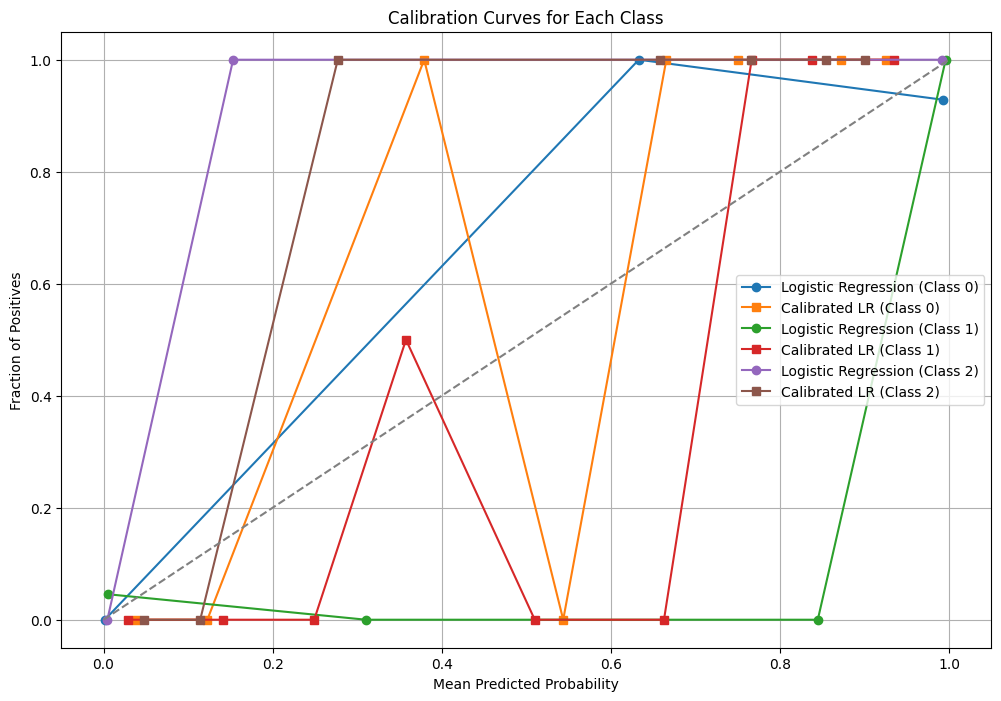

In [62]:
from sklearn.calibration import calibration_curve

plt.figure(figsize=(12, 8))

# Iterate through each class
for i, class_label in enumerate(np.unique(y_test)):
    prob_true, prob_pred = calibration_curve((y_test == class_label).astype(int), 
                                             y_proba1[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='o', label=f'Logistic Regression (Class {class_label})')

    prob_true, prob_pred = calibration_curve((y_test == class_label).astype(int), 
                                             y_proba2[:, i], n_bins=10)
    plt.plot(prob_pred, prob_true, marker='s', label=f'Calibrated LR (Class {class_label})')

# Perfect calibration line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title('Calibration Curves for Each Class')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.grid()
plt.show()


# Density Plot for Predicted Probabilities

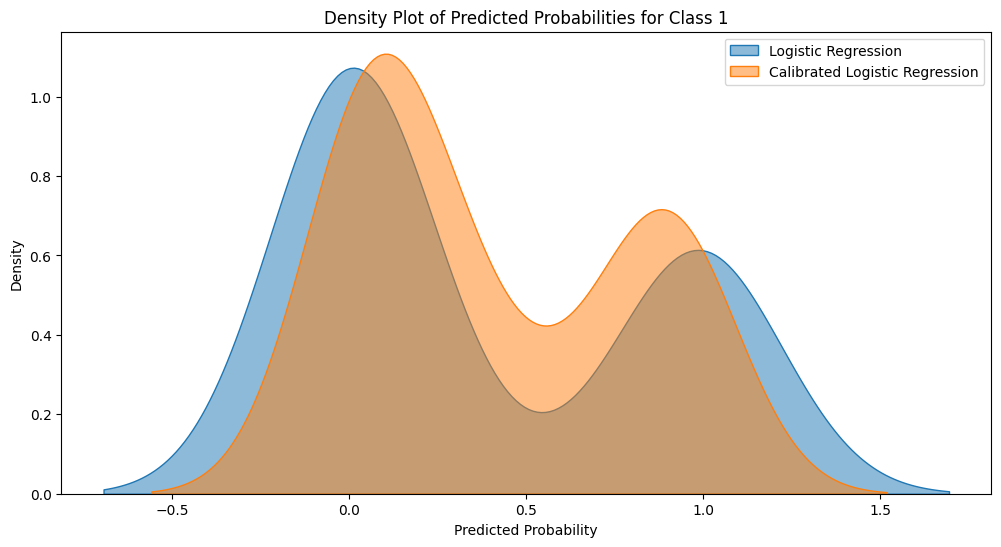

In [63]:
plt.figure(figsize=(12, 6))

# Plot for model1
sns.kdeplot(y_proba1[:, 1], label='Logistic Regression', fill=True, alpha=0.5)

# Plot for model2
sns.kdeplot(y_proba2[:, 1], label='Calibrated Logistic Regression', fill=True, alpha=0.5)

plt.title('Density Plot of Predicted Probabilities for Class 1')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.show()


# Scatter Plot for Direct Comparison

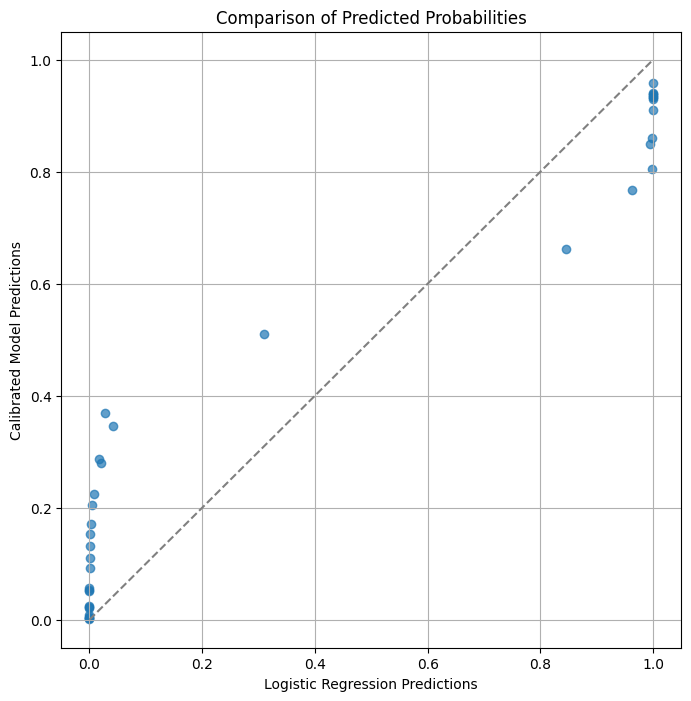

In [64]:
plt.figure(figsize=(8, 8))
plt.scatter(y_proba1[:, 1], y_proba2[:, 1], alpha=0.7)
plt.plot([0, 1], [0, 1], '--', color='gray')  # Line for perfect agreement

plt.title('Comparison of Predicted Probabilities')
plt.xlabel('Logistic Regression Predictions')
plt.ylabel('Calibrated Model Predictions')
plt.grid()
plt.show()


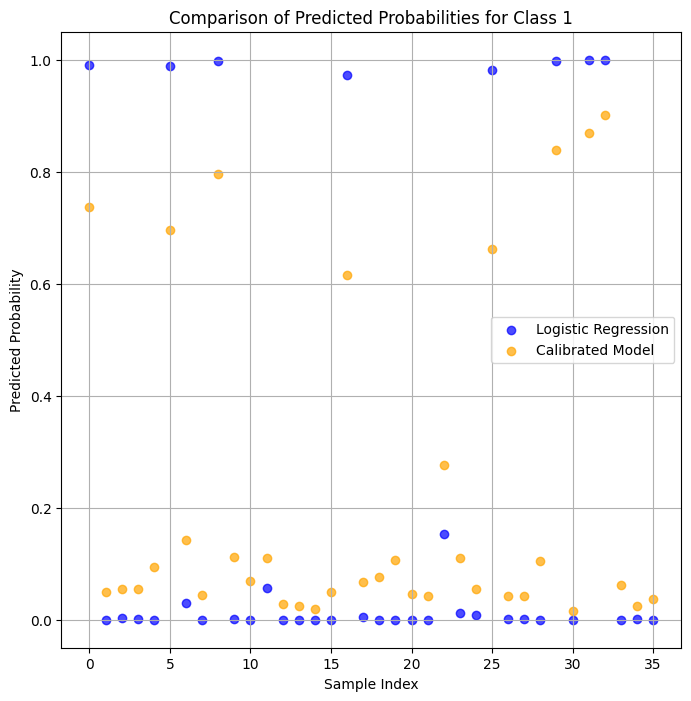

In [66]:
plt.figure(figsize=(8, 8))

# Scatter plot to compare probabilities of class 1
plt.scatter(range(len(y_proba1[:, 2])), y_proba1[:, 2], alpha=0.7, label='Logistic Regression', color='blue')
plt.scatter(range(len(y_proba2[:, 2])), y_proba2[:, 2], alpha=0.7, label='Calibrated Model', color='orange')

plt.title('Comparison of Predicted Probabilities for Class 1')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.legend()
plt.grid()
plt.show()
